tgb - 11/27/2019 - The goal of this network is to reinterpolate the NN in epsilon vertical coordinates back to the host grid to compare its performances with the pressure-gridded model

# 0) Imports

In [1]:
from cbrain.imports import *
from cbrain.data_generator import *
from cbrain.cam_constants import *
from cbrain.losses import *
from cbrain.utils import limit_mem
from cbrain.layers import *
from cbrain.data_generator import DataGenerator
import tensorflow as tf
import tensorflow.math as tfm
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import xarray as xr
import numpy as np
from cbrain.model_diagnostics import ModelDiagnostics
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as imag
import scipy.integrate as sin

TRAINDIR = '/local/Tom.Beucler/SPCAM_PHYS/'
DATADIR = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/'
PREFIX = '8col009_01_'
%cd /filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM

# Otherwise tensorflow will use ALL your GPU RAM for no reason
limit_mem()

/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages

/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog


W1129 19:42:53.745960 22962068838208 deprecation_wrapper.py:119] From /home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/utils.py:145: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W1129 19:42:53.746460 22962068838208 deprecation_wrapper.py:119] From /home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/utils.py:148: The name tf.keras.backend.set_session is deprecated. Please use tf.compat.v1.keras.backend.set_session instead.

W1129 19:42:53.746968 22962068838208 deprecation_wrapper.py:119] From /home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/utils.py:148: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM


# 1) Calculate outputs of eps NN

In [2]:
# Indices of different variables
PHQ_idx = slice(0,30)
TPHYSTND_idx = slice(30,60)
PHQEPS_idx = slice(0,100)
TPHYSTNDEPS_idx = slice(100,200)

## 1.1) Define models

In [4]:
config_fn = ['/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/104_PostProc.yml',
            '/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/132_PostProc.yml']
data0K_fn = ['/local/Tom.Beucler/SPCAM_PHYS/104_valid.nc',
            '/local/Tom.Beucler/SPCAM_PHYS/132_valid.nc']
data4K_fn = ['/local/Tom.Beucler/SPCAM_PHYS/105_valid.nc',
            '/local/Tom.Beucler/SPCAM_PHYS/133_valid.nc']
NNarray = ['POG104','POG132']
NNname = ['RH T','RHeps Teps']

In [5]:
NN = {}; md0 = {}; md4 = {};
%cd $TRAINDIR/HDF5_DATA
for i,NNs in enumerate(NNarray):
    print('NN name is ',NNs)
    path = TRAINDIR+'HDF5_DATA/'+NNs+'.hdf5'
    #NN[NNs] = load_model(path,custom_objects=dict_lay)
    NN[NNs] = load_model(path)
    md0[NNs] = ModelDiagnostics(NN[NNs],config_fn[i],data0K_fn[i])
    md4[NNs] = ModelDiagnostics(NN[NNs],config_fn[i],data4K_fn[i])

W1129 20:08:57.065258 22962068838208 deprecation.py:506] From /home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1129 20:08:57.065824 22962068838208 deprecation.py:506] From /home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1129 20:08:57.066820 22962068838208 deprecation.py:506] From /home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros

/scratch-local/Tom.Beucler/SPCAM_PHYS/HDF5_DATA
NN name is  POG104


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


NN name is  POG132


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


## 1.2) Evaluate NN on samples

In [6]:
lat_ind = np.arange(0,64)
iini = 120
iend = 130

for isim in range(2):
    print('isim=',isim)
    if isim==0: md = md0
    elif isim==1: md = md4
    diagno = {} # Diagnostics structure
    diagno['truth'] = {} # Diagnostics structure for the truth
    for i,NNs in enumerate([NNarray[1]]):
        diagno[NNs] = {} # Diagnostics structure for each NN
        for itime in tqdm(np.arange(iini,iend)):
            # Get input, prediction and truth from NN
            inp, p, truth = md[NNs].get_inp_pred_truth(itime)  # [lat, lon, var, lev]
            # Get convective heating and moistening for each NN
            if itime==iini:
                if i==0:
                    diagno['truth']['PHQEPS'] = md[NNs].reshape_ngeo(truth[:,PHQEPS_idx])[lat_ind,:,:,np.newaxis]
                    diagno['truth']['TPHYSTNDEPS'] = md[NNs].reshape_ngeo(truth[:,TPHYSTNDEPS_idx])[lat_ind,:,:,np.newaxis]
                diagno[NNs]['PHQEPS'] = md[NNs].reshape_ngeo(p[:,PHQEPS_idx])[lat_ind,:,:,np.newaxis]
                diagno[NNs]['TPHYSTNDEPS'] = md[NNs].reshape_ngeo(p[:,TPHYSTNDEPS_idx])[lat_ind,:,:,np.newaxis]
            else:
                for istr,field in enumerate(['PHQEPS','TPHYSTNDEPS']):
                    if field=='PHQEPS': ind_field = PHQEPS_idx
                    elif field=='TPHYSTNDEPS': ind_field = TPHYSTNDEPS_idx
                    diagno[NNs][field] = np.concatenate((diagno[NNs][field],
                                                         md[NNs].reshape_ngeo(p[:,ind_field])[lat_ind,:,:,np.newaxis]),
                                                        axis=3)
                    if i==0:
                        diagno['truth'][field] = np.concatenate((diagno['truth'][field],
                                                                 md[NNs].reshape_ngeo(truth[:,ind_field])[lat_ind,:,:,np.newaxis]),
                                                                axis=3)
    if isim==0: diagno0 = diagno
    elif isim==1: diagno4 = diagno

isim= 0



isim= 1


In [7]:
eps_res = 100
eps_NN = np.linspace(0,1,eps_res)

Text(0, 0.5, 'eps')

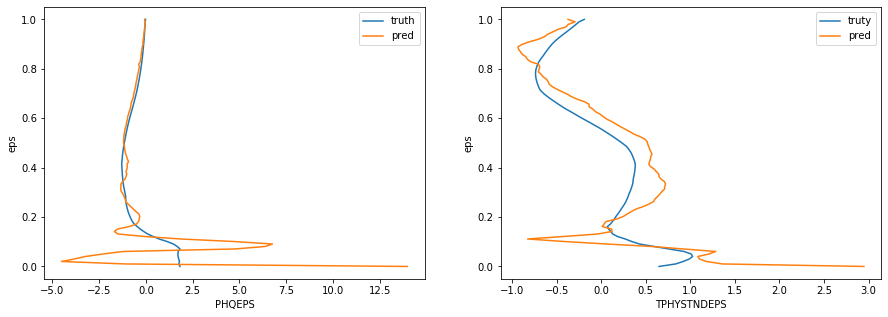

In [9]:
diagno = diagno4

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(np.mean(diagno['truth']['PHQEPS'],axis=(0,1,3)),eps_NN,label='truth')
plt.plot(np.mean(diagno[NNs]['PHQEPS'],axis=(0,1,3)),eps_NN,label='pred')
plt.legend()
plt.xlabel('PHQEPS')
plt.ylabel('eps')

plt.subplot(1,2,2)
plt.plot(np.mean(diagno['truth']['TPHYSTNDEPS'],axis=(0,1,3)),eps_NN,label='truty')
plt.plot(np.mean(diagno[NNs]['TPHYSTNDEPS'],axis=(0,1,3)),eps_NN,label='pred')
plt.legend()
plt.xlabel('TPHYSTNDEPS')
plt.ylabel('eps')

## 1.3) Track down lack of generalization in eps coordinates

tgb - 11/28/2019 - From the analysis above, the lack of generalization in eps coordinates does not come from the interpolation but from the model itself. The goal is to track down the origin of this lack of generalization skill.

In [58]:
# Load coordinates
coor = xr.open_dataset("/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/AndKua_aqua_SPCAM3.0_sp_fbp_f4.cam2.h1.0000-01-01-00000.nc",\
                    decode_times=False)
lat = coor.lat; lon = coor.lon; lev = coor.lev;
coor.close();

In [11]:
data133 = xr.open_dataset("/local/Tom.Beucler/SPCAM_PHYS/133_valid.nc",decode_times=False)

In [12]:
data133.vars.shape

(3530752, 408)

In [13]:
data132 = xr.open_dataset("/local/Tom.Beucler/SPCAM_PHYS/132_valid.nc",decode_times=False)

In [14]:
data132.vars.shape

(18776064, 408)

In [61]:
data104 = xr.open_dataset("/local/Tom.Beucler/SPCAM_PHYS/104_valid.nc",decode_times=False)

In [62]:
data105 = xr.open_dataset("/local/Tom.Beucler/SPCAM_PHYS/105_valid.nc",decode_times=False)

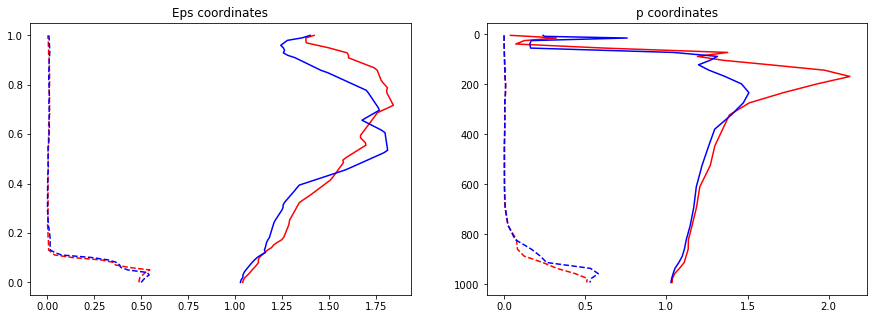

In [63]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title('Eps coordinates')
plt.plot(np.max(data133.vars[9000:15000,:100],axis=0),eps_NN,color='r',linestyle='-')
plt.plot(np.min(data133.vars[9000:15000,:100],axis=0),eps_NN,color='r',linestyle='--')
plt.plot(np.max(data132.vars[9000:15000,:100],axis=0),eps_NN,color='b',linestyle='-')
plt.plot(np.min(data132.vars[9000:15000,:100],axis=0),eps_NN,color='b',linestyle='--')

plt.subplot(1,2,2)
plt.title('p coordinates')
plt.plot(np.max(data105.vars[9000:15000,:30],axis=0),lev,color='r',linestyle='-')
plt.plot(np.min(data105.vars[9000:15000,:30],axis=0),lev,color='r',linestyle='--')
plt.plot(np.max(data104.vars[9000:15000,:30],axis=0),lev,color='b',linestyle='-')
plt.plot(np.min(data104.vars[9000:15000,:30],axis=0),lev,color='b',linestyle='--')
plt.gca().invert_yaxis()

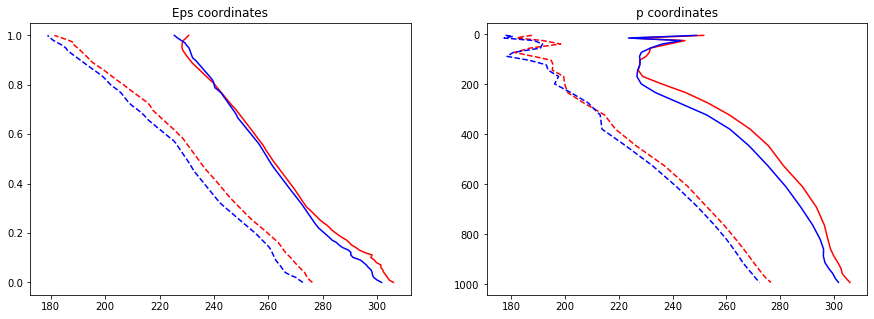

In [64]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title('Eps coordinates')
plt.plot(np.max(data133.vars[9000:15000,100:200],axis=0),eps_NN,color='r',linestyle='-')
plt.plot(np.min(data133.vars[9000:15000,100:200],axis=0),eps_NN,color='r',linestyle='--')
plt.plot(np.max(data132.vars[9000:15000,100:200],axis=0),eps_NN,color='b',linestyle='-')
plt.plot(np.min(data132.vars[9000:15000,100:200],axis=0),eps_NN,color='b',linestyle='--')

plt.subplot(1,2,2)
plt.title('p coordinates')
plt.plot(np.max(data105.vars[9000:15000,30:60],axis=0),lev,color='r',linestyle='-')
plt.plot(np.min(data105.vars[9000:15000,30:60],axis=0),lev,color='r',linestyle='--')
plt.plot(np.max(data104.vars[9000:15000,30:60],axis=0),lev,color='b',linestyle='-')
plt.plot(np.min(data104.vars[9000:15000,30:60],axis=0),lev,color='b',linestyle='--')
plt.gca().invert_yaxis()

## 1.4) Permute features within dataset for feature importance ranking

### 1.4.1) Which features are responsible for the bad generalizing in PHQ at +4K?

In [158]:
lat_ind = np.arange(0,64)
iini = 20
iend = 21
feat_rand = np.rint(200+220*np.random.rand(204,(iend-iini+1))).astype('int') # Between 200 and 420

for isim in range(2):
    print('isim=',isim)
    if isim==0: md = md0
    elif isim==1: md = md4
    diagno = {} # Diagnostics structure
    diagno['truth'] = {}
    for ifeature in range(205):
        diagno['truth'][str(ifeature)] = {} # Diagnostics structure for the truth
    for i,NNs in enumerate([NNarray[1]]):
        diagno[NNs] = {} # Diagnostics structure for each NN
        for ifeature in range(205):
            diagno[NNs][str(ifeature)] = {}
        for itime in tqdm(np.arange(iini,iend)):
            for ifeature in range(205):
                print('feature=',ifeature,'/204','              ',end='\r')
                # Get input, prediction and truth from NN
                if ifeature<204:
                    inp, truth = md[NNs].valid_gen[itime]  # [lat, lon, var, lev]
                    truth = truth.values
                    inp_rand, tmp = md[NNs].valid_gen[feat_rand[ifeature,itime-iini]]
                    p = md[NNs].model.predict_on_batch(np.concatenate((inp[:,:ifeature],
                                                                       np.transpose(np.expand_dims(inp_rand[:,ifeature],axis=0)),
                                                                       inp[:,ifeature+1:]),axis=1))
                else:
                    # Get input, prediction and truth from NN
                    inp, p, truth = md[NNs].get_inp_pred_truth(itime)  # [lat, lon, var, lev]
                # Get convective heating and moistening for each NN
                if itime==iini:
                    if i==0:
                        diagno['truth'][str(ifeature)]['PHQEPS'] = md[NNs].reshape_ngeo(truth[:,PHQEPS_idx])[lat_ind,:,:,np.newaxis]
                        diagno['truth'][str(ifeature)]['TPHYSTNDEPS'] = md[NNs].reshape_ngeo(truth[:,TPHYSTNDEPS_idx])[lat_ind,:,:,np.newaxis]
                    diagno[NNs][str(ifeature)]['PHQEPS'] = md[NNs].reshape_ngeo(p[:,PHQEPS_idx])[lat_ind,:,:,np.newaxis]
                    diagno[NNs][str(ifeature)]['TPHYSTNDEPS'] = md[NNs].reshape_ngeo(p[:,TPHYSTNDEPS_idx])[lat_ind,:,:,np.newaxis]
                else:
                    for istr,field in enumerate(['PHQEPS','TPHYSTNDEPS']):
                        if field=='PHQEPS': ind_field = PHQEPS_idx
                        elif field=='TPHYSTNDEPS': ind_field = TPHYSTNDEPS_idx
                        diagno[NNs][str(ifeature)][field] = np.concatenate((diagno[NNs][str(ifeature)][field],
                                                             md[NNs].reshape_ngeo(p[:,ind_field])[lat_ind,:,:,np.newaxis]),
                                                            axis=3)
                        if i==0:
                            diagno['truth'][str(ifeature)][field] = np.concatenate((diagno['truth'][str(ifeature)][field],
                                                                     md[NNs].reshape_ngeo(truth[:,ind_field])[lat_ind,:,:,np.newaxis]),
                                                                    axis=3)
    if isim==0: diagno0 = diagno
    elif isim==1: diagno4 = diagno

isim= 0


isim= 1= 204 /204               


Predicted field without permutation of inputs

Text(0, 0.5, 'eps')

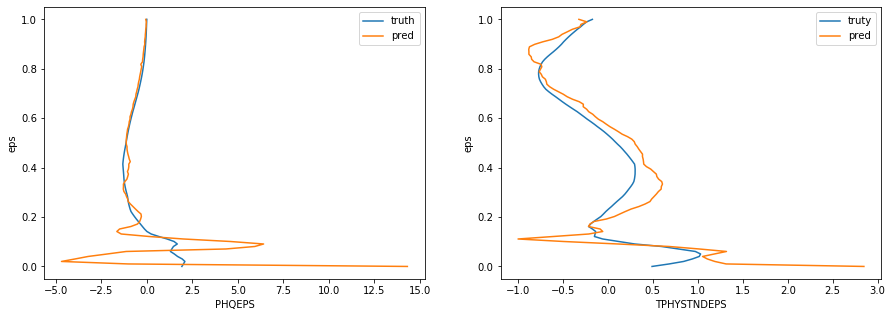

In [193]:
diagno = diagno4
ifeature = 204

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(np.mean(diagno['truth'][str(ifeature)]['PHQEPS'],axis=(0,1,3)),eps_NN,label='truth')
plt.plot(np.mean(diagno[NNs][str(ifeature)]['PHQEPS'],axis=(0,1,3)),eps_NN,label='pred')
plt.legend()
plt.xlabel('PHQEPS')
plt.ylabel('eps')

plt.subplot(1,2,2)
plt.plot(np.mean(diagno['truth'][str(ifeature)]['TPHYSTNDEPS'],axis=(0,1,3)),eps_NN,label='truty')
plt.plot(np.mean(diagno[NNs][str(ifeature)]['TPHYSTNDEPS'],axis=(0,1,3)),eps_NN,label='pred')
plt.legend()
plt.xlabel('TPHYSTNDEPS')
plt.ylabel('eps')

In [176]:
diagno = diagno0
dist_fromtruth0 = np.zeros((205,100))
for ifeature in range(205):
    dist_fromtruth0[ifeature,:] = np.mean(np.abs(diagno[NNs][str(ifeature)]['PHQEPS']-\
                                                diagno['truth'][str(ifeature)]['PHQEPS']),axis=(0,1,3))

diagno = diagno4
dist_fromtruth4 = np.zeros((205,100))
for ifeature in range(205):
    dist_fromtruth4[ifeature,:] = np.mean(np.abs(diagno[NNs][str(ifeature)]['PHQEPS']-\
                                                diagno['truth'][str(ifeature)]['PHQEPS']),axis=(0,1,3))

Text(0.5, 1.0, 'Average absolute Distance of lowest 20 levels of PHQ from the truth (W/m2)')

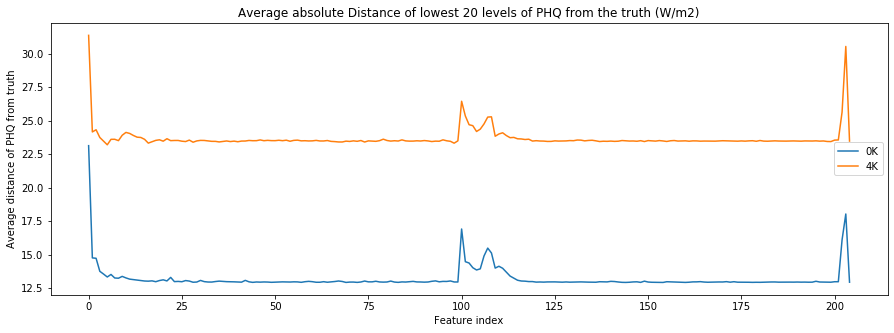

In [191]:
plt.figure(figsize=(15,5))
plt.plot(np.mean(dist_fromtruth0[:,[0]],axis=1),label='0K')
plt.plot(np.mean(dist_fromtruth4[:,[0]],axis=1),label='4K')
plt.legend()
plt.xlabel('Feature index')
plt.ylabel('Average distance of PHQ from truth')
plt.title('Average absolute Distance of lowest 20 levels of PHQ from the truth (W/m2)')

Text(0.5, 1.0, 'Average distance of PHQ from truth relative to non permuted')

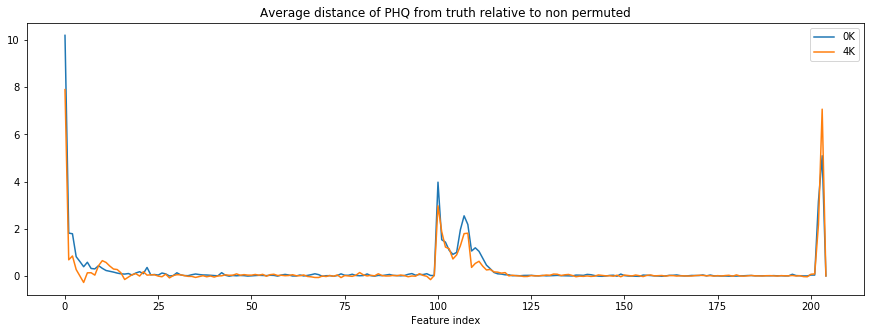

In [192]:
plt.figure(figsize=(15,5))
plt.plot(np.mean(dist_fromtruth0[:,[0]]-dist_fromtruth0[204,[0]],axis=1),label='0K')
plt.plot(np.mean(dist_fromtruth4[:,[0]]-dist_fromtruth4[204,[0]],axis=1),label='4K')
plt.legend()
plt.xlabel('Feature index')
plt.title('Average distance of PHQ from truth relative to non permuted')

### 1.4.2) What about TPHYSTND?

## 1.5) Try with only 30 levels to understand where generalization error comes from

# 2) Interpolate back and forth

In [41]:
iini = 5
iend = 10
for itime in tqdm(np.arange(iini,iend)):
    # Get input, prediction and truth from NN
    inp_norm104, p, truth = md['POG104'].get_inp_pred_truth(itime)  # [lat, lon, var, lev]

In [42]:
inp = inp_norm104*md['POG104'].valid_gen.input_transform.div+\
md['POG104'].valid_gen.input_transform.sub

In [43]:
# Load data
pathPKL = '/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/'
hf = open(pathPKL+'2019_11_22_imin_TNS_logfit.pkl','rb')
imfit = pickle.load(hf)['logmodel'][0]
hf = open(pathPKL+'2019_11_22_eps_TNS_linfit.pkl','rb')
epfit = pickle.load(hf)['linmodel']

In [45]:
# Layer input
# x = The NN input 
# x.shape=(batch size,# inputs)
# Layer output
# x_interp = The NN input interpolated on the custom eps grid
# x_interp.shape=(batch size,custom eps grid size)
# Parameters
eps_res = 100
# eps_res = Resolution of the eps grid

x_test = inp
# 1) Generate eps grid for the neural network with vertical resolution eps_res
# and the interpolated input array
eps_NN = np.linspace(0,1,eps_res)
x_interp = np.zeros((x_test.shape[0],int(x_test.shape[1]+2*(eps_res-30))))

# 2) Extract temperature and moisture from input vector
q = x_test[:,:30]
T = x_test[:,30:60]

# 3) Calculates vertical interpolation domain [imin_eval:] and eps coordinate as a function of NS T = T[30]
for isample in range(T.shape[0]):
    x = T[isample,-1]
    imin_eval = int(np.rint(10**(imfit[0]*np.log10(x)**0+imfit[1]*np.log10(x)**1+\
                                 imfit[2]*np.log10(x)**2+imfit[3]*np.log10(x)**3+\
                                 imfit[4]*np.log10(x)**4)))
    eps_eval = epfit[:,0]*x**0+epfit[:,1]*x**1+epfit[:,2]*x**2+epfit[:,3]*x**3+epfit[:,4]*x**4
    # tgb - 11/23/2019 - Adds dummy 1 at the end because np.where evaluates y output even if condition false and not returning y
    eps_test = np.minimum(1,np.maximum(eps_eval,0))[imin_eval:]
    eps_eval = np.concatenate((np.minimum(1,np.maximum(eps_eval,0))[imin_eval:][::-1],[1]))
    
# 4) Interpolate both T and q to the eps grid for the neural network
# 4.1) Thermodynamic profiles to interpolate
# tgb - 11/23/2019 - Adds dummy zero at the end because np.where evaluates y output even if condition false and not returning y
    T_input = np.concatenate((T[isample,imin_eval:][::-1],[0]))
    q_input = np.concatenate((q[isample,imin_eval:][::-1],[0]))
# 4.2) Interpolation using searchsorted and low-level weighting implementation
# The goal is to mimic T_interp = np.interp(x=eps_ref,xp=eps_eval,fp=T_input)
# If left then T_input[0], if right then T_input[-1], else weighted average of T_input[iint-1] and T_input[iint]
    iint = np.searchsorted(eps_eval,eps_NN)
    T_interp = np.where(iint<1,T_input[0],np.where(iint>(30-imin_eval-1),T_input[30-imin_eval-1],\
                                                   ((eps_eval[iint]-eps_NN)/(eps_eval[iint]-eps_eval[iint-1]))*T_input[iint-1]+\
                                                   ((eps_NN-eps_eval[iint-1])/(eps_eval[iint]-eps_eval[iint-1]))*T_input[iint]))
    q_interp = np.where(iint<1,q_input[0],np.where(iint>(30-imin_eval-1),q_input[30-imin_eval-1],\
                                                   ((eps_eval[iint]-eps_NN)/(eps_eval[iint]-eps_eval[iint-1]))*q_input[iint-1]+\
                                                   ((eps_NN-eps_eval[iint-1])/(eps_eval[iint]-eps_eval[iint-1]))*q_input[iint]))

# 5) Return the interpolated input vector x_interp
    x_interp[isample,:] = np.concatenate((q_interp,T_interp,x_test[isample,60:]))

In [51]:
inp_norm131 = (x_interp-md['POG131'].valid_gen.input_transform.sub)/\
md['POG131'].valid_gen.input_transform.div

In [53]:
pred131 = md['POG131'].model.predict_on_batch(inp_norm131)

In [58]:
PS = 1e5
eps_res = 1e2
dP = PS/eps_res

In [59]:
predeps = pred131/md['POG131'].valid_gen.output_transform.scale

In [69]:
y = np.zeros((T.shape[0],64))
for isample in range(T.shape[0]):
    x = T[isample,-1]
    imin_eval = int(np.rint(10**(imfit[0]*np.log10(x)**0+imfit[1]*np.log10(x)**1+\
                                 imfit[2]*np.log10(x)**2+imfit[3]*np.log10(x)**3+\
                                 imfit[4]*np.log10(x)**4)))
    eps_eval = epfit[:,0]*x**0+epfit[:,1]*x**1+epfit[:,2]*x**2+epfit[:,3]*x**3+epfit[:,4]*x**4
    # tgb - 11/23/2019 - Adds dummy 1 at the end because np.where evaluates y output even if condition false and not returning y
    eps_test = np.minimum(1,np.maximum(eps_eval,0))[imin_eval:]
    eps_eval = np.concatenate((np.minimum(1,np.maximum(eps_eval,0))[imin_eval:][::-1],[1]))
    
# 4) Interpolate both T and q to the eps grid for the neural network
# 4.1) Thermodynamic profiles to interpolate
# tgb - 11/23/2019 - Adds dummy zero at the end because np.where evaluates y output even if condition false and not returning y
    dqdt_output = predeps[isample,:100]
    dTdt_output = predeps[isample,100:200]
    #T_input = np.concatenate((T[isample,imin_eval:][::-1],[0]))
    #q_input = np.concatenate((q[isample,imin_eval:][::-1],[0]))
# 4.2) Interpolation using searchsorted and low-level weighting implementation
# The goal is to mimic T_interp = np.interp(x=eps_ref,xp=eps_eval,fp=T_input)
# If left then T_input[0], if right then T_input[-1], else weighted average of T_input[iint-1] and T_input[iint]
    iint = np.searchsorted(eps_NN,eps_eval)
    dTdt_interp = np.where(iint<1,dTdt_output[0],np.where(iint>99,dTdt_output[-1],\
                                                          ((eps_NN[iint]-eps_eval)/(eps_NN[iint]-eps_NN[iint-1]))*dTdt_output[iint-1]+\
                                                          ((eps_eval-eps_NN[iint-1])/(eps_NN[iint]-eps_NN[iint-1]))*dTdt_output[iint]))
    dTdt_interp = np.concatenate((dTdt_interp,np.zeros(imin_eval-1,)))[::-1]
    dqdt_interp = np.where(iint<1,dqdt_output[0],np.where(iint>99,dqdt_output[-1],\
                                                          ((eps_NN[iint]-eps_eval)/(eps_NN[iint]-eps_NN[iint-1]))*dqdt_output[iint-1]+\
                                                          ((eps_eval-eps_NN[iint-1])/(eps_NN[iint]-eps_NN[iint-1]))*dqdt_output[iint]))
    dqdt_interp = np.concatenate((dqdt_interp,np.zeros(imin_eval-1,)))[::-1]
# 5) Return the output vector y
    y[isample,:] = np.concatenate((dqdt_interp,dTdt_interp,predeps[isample,200:204]))

In [75]:
# Convert y to W/m2 to compare them to the truth
y *= md['POG104'].valid_gen.output_transform.scale

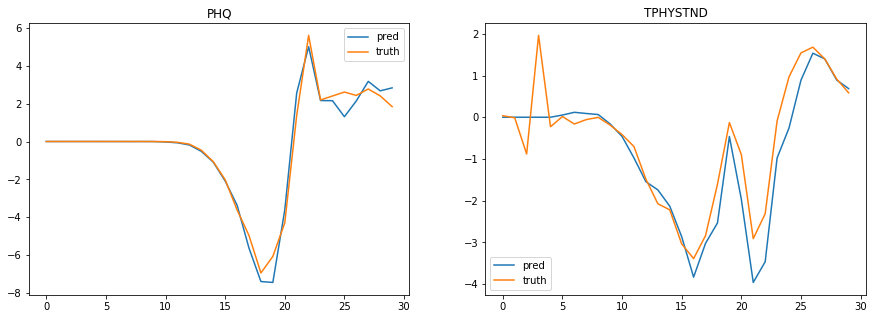

In [85]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title('PHQ')
plt.plot(np.mean(y[:,:30],axis=0),label='pred')
plt.plot(np.mean(truth[:,:30],axis=0),label='truth')
plt.legend()

plt.subplot(1,2,2)
plt.title('TPHYSTND')
plt.plot(np.mean(y[:,30:60],axis=0),label='pred')
plt.plot(np.mean(truth[:,30:60],axis=0),label='truth')
plt.legend()

# 3) Code for several timesteps

In [102]:
config_fn = ['/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/104_PostProc.yml',
            '/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/132_PostProc.yml']
data0K_fn = ['/local/Tom.Beucler/SPCAM_PHYS/104_valid.nc',
            '/local/Tom.Beucler/SPCAM_PHYS/131_valid.nc']
data4K_fn = ['/local/Tom.Beucler/SPCAM_PHYS/105_valid.nc',
            '/local/Tom.Beucler/SPCAM_PHYS/131_valid.nc']
NNarray = ['POG104','POG131']
NNname = ['RH T','RHeps Teps']

In [104]:
NN = {}; md0 = {}; md4 = {};
%cd $TRAINDIR/HDF5_DATA
for i,NNs in enumerate(NNarray):
    print('NN name is ',NNs)
    path = TRAINDIR+'HDF5_DATA/'+NNs+'.hdf5'
    #NN[NNs] = load_model(path,custom_objects=dict_lay)
    NN[NNs] = load_model(path)
    md[NNs] = ModelDiagnostics(NN[NNs],config_fn[i],data0K_fn[i])
    md[NNs+'p4'] = ModelDiagnostics(NN[NNs],config_fn[i],data4K_fn[i])

/scratch-local/Tom.Beucler/SPCAM_PHYS/HDF5_DATA
NN name is  POG104


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


NN name is  POG131


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [106]:
# Load data
pathPKL = '/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/'
hf = open(pathPKL+'2019_11_22_imin_TNS_logfit.pkl','rb')
imfit = pickle.load(hf)['logmodel'][0]
hf = open(pathPKL+'2019_11_22_eps_TNS_linfit.pkl','rb')
epfit = pickle.load(hf)['linmodel']

In [121]:
eps_res = 100
eps_NN = np.linspace(0,1,eps_res)

iini = 100
iend = 115
sREF = 'POG104' # Reference NN in p space
sEPS = 'POG131' # NN in eps space

In [122]:
for itime in tqdm(np.arange(iini,iend)):
    # Get input, prediction and truth from NN
    inp_norm104, p, truth = md[sREF].get_inp_pred_truth(itime)  # [lat, lon, var, lev]
    inp = inp_norm104*md[sREF].valid_gen.input_transform.div+md[sREF].valid_gen.input_transform.sub
    
    x_interp = np.zeros((inp.shape[0],int(inp.shape[1]+2*(eps_res-30))))

    # 2) Extract temperature and moisture from input vector
    q = inp[:,:30]
    T = inp[:,30:60]

    # 3) Calculates vertical interpolation domain [imin_eval:] and eps coordinate as a function of NS T = T[30]
    for isample in range(T.shape[0]):
        x = T[isample,-1]
        imin_eval = int(np.rint(10**(imfit[0]*np.log10(x)**0+imfit[1]*np.log10(x)**1+\
                                     imfit[2]*np.log10(x)**2+imfit[3]*np.log10(x)**3+\
                                     imfit[4]*np.log10(x)**4)))
        eps_eval = epfit[:,0]*x**0+epfit[:,1]*x**1+epfit[:,2]*x**2+epfit[:,3]*x**3+epfit[:,4]*x**4
        # tgb - 11/23/2019 - Adds dummy 1 at the end because np.where evaluates y output even if condition false and not returning y
        eps_test = np.minimum(1,np.maximum(eps_eval,0))[imin_eval:]
        eps_eval = np.concatenate((np.minimum(1,np.maximum(eps_eval,0))[imin_eval:][::-1],[1]))

    # 4) Interpolate both T and q to the eps grid for the neural network
    # 4.1) Thermodynamic profiles to interpolate
    # tgb - 11/23/2019 - Adds dummy zero at the end because np.where evaluates y output even if condition false and not returning y
        T_input = np.concatenate((T[isample,imin_eval:][::-1],[0]))
        q_input = np.concatenate((q[isample,imin_eval:][::-1],[0]))
    # 4.2) Interpolation using searchsorted and low-level weighting implementation
    # The goal is to mimic T_interp = np.interp(x=eps_ref,xp=eps_eval,fp=T_input)
    # If left then T_input[0], if right then T_input[-1], else weighted average of T_input[iint-1] and T_input[iint]
        iint = np.searchsorted(eps_eval,eps_NN)
        T_interp = np.where(iint<1,T_input[0],np.where(iint>(30-imin_eval-1),T_input[30-imin_eval-1],\
                                                       ((eps_eval[iint]-eps_NN)/(eps_eval[iint]-eps_eval[iint-1]))*T_input[iint-1]+\
                                                       ((eps_NN-eps_eval[iint-1])/(eps_eval[iint]-eps_eval[iint-1]))*T_input[iint]))
        q_interp = np.where(iint<1,q_input[0],np.where(iint>(30-imin_eval-1),q_input[30-imin_eval-1],\
                                                       ((eps_eval[iint]-eps_NN)/(eps_eval[iint]-eps_eval[iint-1]))*q_input[iint-1]+\
                                                       ((eps_NN-eps_eval[iint-1])/(eps_eval[iint]-eps_eval[iint-1]))*q_input[iint]))

    # 5) Return the interpolated input vector x_interp
        x_interp[isample,:] = np.concatenate((q_interp,T_interp,x_test[isample,60:]))
        
    inp_norm131 = (x_interp-md[sEPS].valid_gen.input_transform.sub)/md[sEPS].valid_gen.input_transform.div
    pred131 = md[sEPS].model.predict_on_batch(inp_norm131)
    predeps = pred131/md[sEPS].valid_gen.output_transform.scale
    
    y = np.zeros((T.shape[0],64))
    for isample in range(T.shape[0]):
        x = T[isample,-1]
        imin_eval = int(np.rint(10**(imfit[0]*np.log10(x)**0+imfit[1]*np.log10(x)**1+\
                                     imfit[2]*np.log10(x)**2+imfit[3]*np.log10(x)**3+\
                                     imfit[4]*np.log10(x)**4)))
        eps_eval = epfit[:,0]*x**0+epfit[:,1]*x**1+epfit[:,2]*x**2+epfit[:,3]*x**3+epfit[:,4]*x**4
        # tgb - 11/23/2019 - Adds dummy 1 at the end because np.where evaluates y output even if condition false and not returning y
        eps_test = np.minimum(1,np.maximum(eps_eval,0))[imin_eval:]
        eps_eval = np.concatenate((np.minimum(1,np.maximum(eps_eval,0))[imin_eval:][::-1],[1]))

    # 4) Interpolate both T and q to the eps grid for the neural network
    # 4.1) Thermodynamic profiles to interpolate
    # tgb - 11/23/2019 - Adds dummy zero at the end because np.where evaluates y output even if condition false and not returning y
        dqdt_output = predeps[isample,:100]
        dTdt_output = predeps[isample,100:200]
    # 4.2) Interpolation using searchsorted and low-level weighting implementation
    # The goal is to mimic T_interp = np.interp(x=eps_ref,xp=eps_eval,fp=T_input)
    # If left then T_input[0], if right then T_input[-1], else weighted average of T_input[iint-1] and T_input[iint]
        iint = np.searchsorted(eps_NN,eps_eval)
        dTdt_interp = np.where(iint<1,dTdt_output[0],np.where(iint>99,dTdt_output[-1],\
                                                              ((eps_NN[iint]-eps_eval)/(eps_NN[iint]-eps_NN[iint-1]))*dTdt_output[iint-1]+\
                                                              ((eps_eval-eps_NN[iint-1])/(eps_NN[iint]-eps_NN[iint-1]))*dTdt_output[iint]))
        dTdt_interp = np.concatenate((dTdt_interp,np.zeros(imin_eval-1,)))[::-1]
        dqdt_interp = np.where(iint<1,dqdt_output[0],np.where(iint>99,dqdt_output[-1],\
                                                              ((eps_NN[iint]-eps_eval)/(eps_NN[iint]-eps_NN[iint-1]))*dqdt_output[iint-1]+\
                                                              ((eps_eval-eps_NN[iint-1])/(eps_NN[iint]-eps_NN[iint-1]))*dqdt_output[iint]))
        dqdt_interp = np.concatenate((dqdt_interp,np.zeros(imin_eval-1,)))[::-1]
    # 5) Return the output vector y
        y[isample,:] = np.concatenate((dqdt_interp,dTdt_interp,predeps[isample,200:204]))
    y *= md[sREF].valid_gen.output_transform.scale
    
    # Reshape to (lat,lon) grid
    if itime==iini: 
        out = md[sEPS].reshape_ngeo(y)[:,:,:,np.newaxis] 
        tru = md[sEPS].reshape_ngeo(truth)[:,:,:,np.newaxis]
    else:
        out = np.concatenate((out,md[sEPS].reshape_ngeo(y)[:,:,:,np.newaxis]),axis=3)
        tru = np.concatenate((tru,md[sEPS].reshape_ngeo(truth)[:,:,:,np.newaxis]),axis=3)

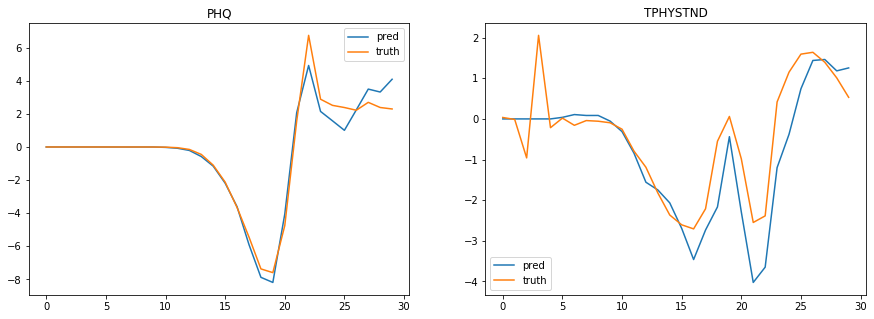

In [123]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title('PHQ')
plt.plot(np.mean(out[:,:,:30,:],axis=(0,1,3)),label='pred')
plt.plot(np.mean(tru[:,:,:30,:],axis=(0,1,3)),label='truth')
plt.legend()

plt.subplot(1,2,2)
plt.title('TPHYSTND')
plt.plot(np.mean(out[:,:,30:60,:],axis=(0,1,3)),label='pred')
plt.plot(np.mean(tru[:,:,30:60,:],axis=(0,1,3)),label='truth')
plt.legend()

In [3]:
# %cd /filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM
# !python preprocessing-11132019.py -c /home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/133_POG_84G_p4K_RHTepsinput_dQdtdTdtepsotuput_June.yml